In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import random
import shutil

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

from tqdm import tqdm

import skimage.io
import skimage.segmentation
import skimage.morphology

# import sys
# __file__ = 'full_experiment.ipynb'
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))

import utils.dirtools  # utils package should has __init__.py in it
import utils.augmentation
import utils.model_builder
import utils.data_provider
import utils.metrics
import utils.objectives
import utils.evaluation
from utils.bltools import remove_border, show

import keras.backend
import keras.callbacks
import keras.layers
import keras.models
import keras.optimizers
import tensorflow as tf

from config import config_vars

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def empty_dir(folder):
    print('empty directory: ', folder)
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path): shutil.rmtree(file_path)
        except Exception as e:
            print(e)

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# build session running on GPU 1
configuration = tf.ConfigProto()
configuration.gpu_options.allow_growth = True
# configuration.gpu_options.visible_device_list = "0, 1"
session = tf.Session(config = configuration)

# apply session
keras.backend.set_session(session)

Using TensorFlow backend.


In [2]:
config_vars["root_directory"] = 'DATA/FISH/'
experiment_name = '00'

config_vars = utils.dirtools.setup_working_directories(config_vars)
config_vars = utils.dirtools.setup_experiment(config_vars, experiment_name)
os.makedirs(config_vars["normalized_images_dir"], exist_ok=True)
os.makedirs(config_vars["boundary_labels_dir"], exist_ok=True)

In [3]:
config_vars["mat_label_dir"] = 'DATA/FISH/raw_annotations/raw_masks/'

In [5]:
config_vars

In [4]:
valid_list = os.listdir(config_vars["mat_label_dir"])
valid_list = sorted([x for x in valid_list if x.endswith('png')])

list_train = []
list_test = []
list_valid = valid_list

# fd_list = sorted(os.listdir('DATA/LineageTracking/raw_images/'))
# valid_fd_list = fd_list[60:]
# for f in valid_fd_list:
#     tmp_list = os.listdir('DATA/LineageTracking/boundary_labels/' + f)
#     tmp_list = [x for x in tmp_list if x.endswith('png')]
#     for e in sorted(tmp_list):
#         list_valid.append(f + '/' + e)


utils.dirtools.write_path_files(config_vars["path_files_training"], list_train)
utils.dirtools.write_path_files(config_vars["path_files_validation"], list_valid)
utils.dirtools.write_path_files(config_vars["path_files_test"], list_test)

# read txt file into dict partitions with 3 list for train/valid/test
data_partitions = utils.dirtools.read_data_partitions(config_vars, load_augmented=False)

In [10]:
%%time
"""Metrics 计算

Jaccard: IOU match average

True Pos: IOU match and only one match
False Pos: extra pred label match non gt
False Neg: missed gt label match non pred
Precision: TP / (TP + FP + 1e-9)
Recall: TP / (TP + FN)
F1: 2 * TP / (2 * TP + FP + FN + 1e-9)

False_neg area: missed gt label area

Merge: one pred label match two gt label
Split: one gt label match two pred label

"""

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Precision", "Recall", "Jaccard", \
                                "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

compare_dir = config_vars["mat_label_dir"]  # labels_out_dir  mat_label_dir
all_images = data_partitions["validation"]

for image_name in all_images:
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    pred_filename = os.path.join(compare_dir, image_name)
    prediction = skimage.io.imread(pred_filename)

    # no effect on matlab results, but needed for predicted results
    ground_truth = remove_border(ground_truth)
    prediction = remove_border(prediction)
    
    ground_truth = skimage.morphology.label(ground_truth)
    prediction = skimage.morphology.label(prediction)
    
#     Apply object dilation don't do for matlab results
#     if config_vars["object_dilation"] > 0:
#         struct = skimage.morphology.square(config_vars["object_dilation"])
#         prediction = skimage.morphology.dilation(prediction, struct)
#     elif config_vars["object_dilation"] < 0:
#         struct = skimage.morphology.square(-config_vars["object_dilation"])
#         prediction = skimage.morphology.erosion(prediction, struct)
        
    
    # Compute evaluation metrics
    # Add result into pd dataframe one by one
    results = utils.evaluation.compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = utils.evaluation.get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    splits_merges = utils.evaluation.get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )


CPU times: user 12.5 s, sys: 56 ms, total: 12.5 s
Wall time: 12.7 s


In [ ]:
%%time
# 图片展示

compare_dir = config_vars["labels_out_dir"]  # labels_out_dir  mat_label_dir
all_images = data_partitions["validation"]  

for i, image_name in enumerate(all_images):
    img_filename = os.path.join(config_vars["raw_annotations_dir"], image_name)
    ground_truth = skimage.io.imread(img_filename)
    pred_filename = os.path.join(compare_dir, image_name)
    prediction = skimage.io.imread(pred_filename)

    ground_truth = remove_border(ground_truth)
    prediction = remove_border(prediction)
    
    ground_truth = skimage.morphology.label(ground_truth)
    prediction = skimage.morphology.label(prediction)
    
    # Apply object dilation
    if config_vars["object_dilation"] > 0:
        struct = skimage.morphology.square(config_vars["object_dilation"])
        prediction = skimage.morphology.dilation(prediction, struct)
    elif config_vars["object_dilation"] < 0:
        struct = skimage.morphology.square(-config_vars["object_dilation"])
        prediction = skimage.morphology.erosion(prediction, struct)

    show(ground_truth, prediction, image_name=image_name)

In [11]:
# average over 10 different threshold

average_performance = results.groupby(["Threshold"]).mean().reset_index()
average_performance

,Threshold,F1,Precision,Recall,Jaccard
0,0.50,0.917978,0.875564,0.971831,0.854082
1,0.55,0.912040,0.869818,0.965661,0.854082
2,0.60,0.906691,0.864643,0.960105,0.854082
3,0.65,0.899060,0.857400,0.951978,0.854082
4,0.70,0.892907,0.851458,0.945570,0.854082
5,0.75,0.879899,0.839159,0.931644,0.854082
6,0.80,0.863950,0.823968,0.914719,0.854082
7,0.85,0.841131,0.802487,0.890174,0.854082
8,0.90,0.819863,0.782334,0.867485,0.854082
9,0.95,0.795466,0.758973,0.841788,0.854082


In [12]:
R = results.groupby(["Image"]).mean().reset_index()
# R.sort_values(by="F1", ascending=False).reset_index()
# R

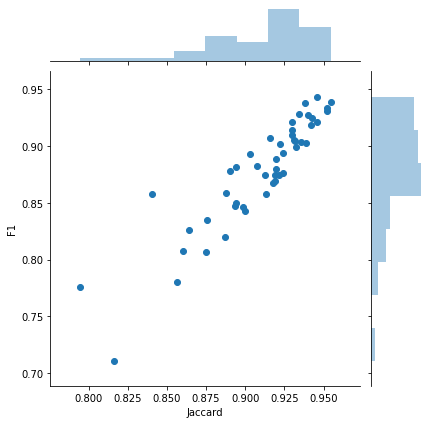

In [35]:
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

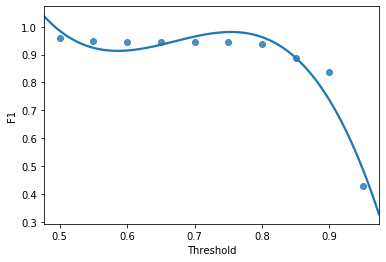

In [52]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)

In [13]:
# Compute and print Average F1
average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0, 250, 625, 900, 10000], # Area intervals
        labels = ["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

# Summarize splits and merges

print("Splits:", np.sum(splits_merges["Splits"]))
print("Merges:", np.sum(splits_merges["Merges"]))

# Report false positives

print("Extra objects (false postives): ", 
      results[results["Threshold"].round(3) == 0.7].sum()["FP"])

Average F1 score: 0.8728984539460087
Jaccard index: 0.854081911158383
Splits: 15
Merges: 62
Extra objects (false postives):  588


In [53]:
splits_merges

,Image_Name,Merges,Splits
1,0000.png,0,1
2,0001.png,0,3
3,0002.png,0,0
4,0003.png,0,1
5,0004.png,0,0
6,0005.png,0,0
7,0006.png,0,1
8,0007.png,0,1
9,0008.png,0,0
10,0009.png,0,0
